<a href="https://colab.research.google.com/github/karlacuv/MCD_Procesamiento/blob/main/Tarea8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Análisis de Audio
### Karla Cureño Vega - 2085376

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import librosa

/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


In [3]:
audio_data = '/content/drive/MyDrive/Files/MCD/Procesamiento y Clasificación de Datos/Semana 10 - Análisis de Audio/Data/genres_original/blues/blues.00025.wav'
x , sr = librosa.load(audio_data)
print(type(x), type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [4]:
librosa.load(audio_data, sr=44100)

(array([-0.03321765, -0.04847718, -0.05033922, ..., -0.00884099,
        -0.00809206, -0.00451813], dtype=float32), 44100)

In [5]:
import IPython.display as ipd
ipd.Audio(audio_data)

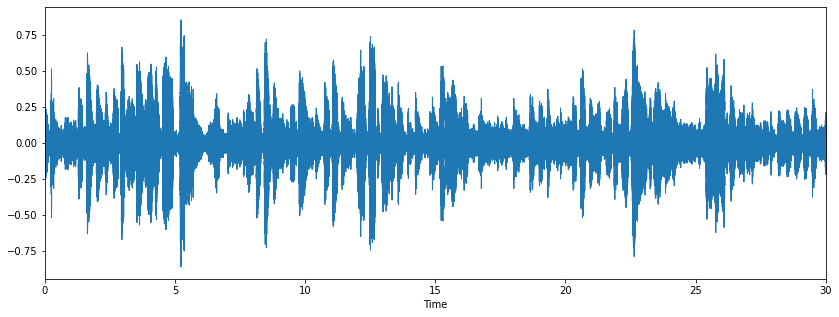

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

### Espectograma

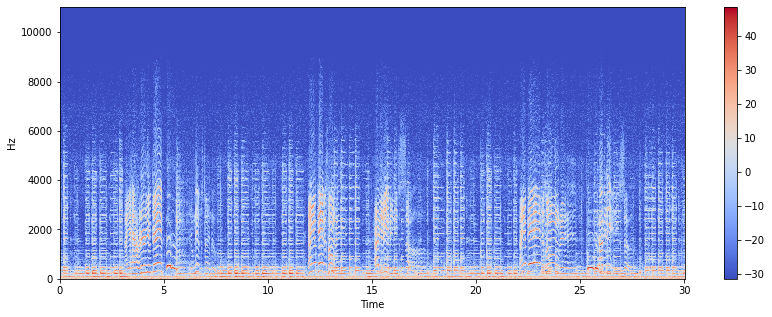

In [7]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

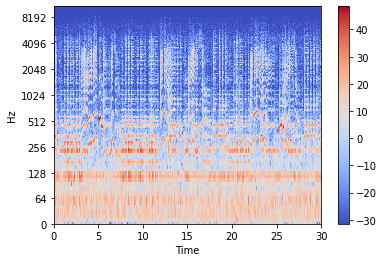

In [8]:
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

### Extracción de Características Principales

### Centroide Espectral

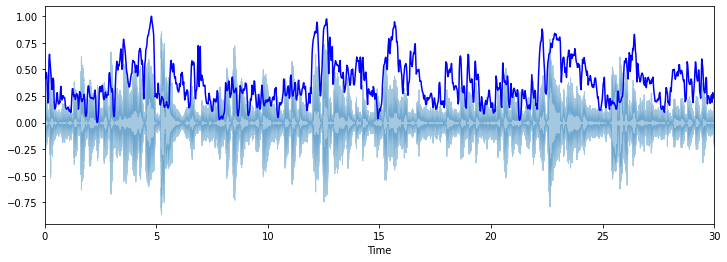

In [9]:
import sklearn
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
spectral_centroids.shape
(775,)
# Computing the time variable for visualization
plt.figure(figsize=(12, 4))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
#Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='b')

### Rolloff Espectral

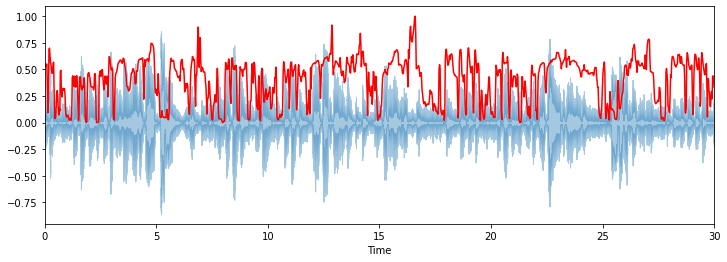

In [10]:
spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=sr)[0]
plt.figure(figsize=(12, 4))
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')

### Ancho de banda Espectral

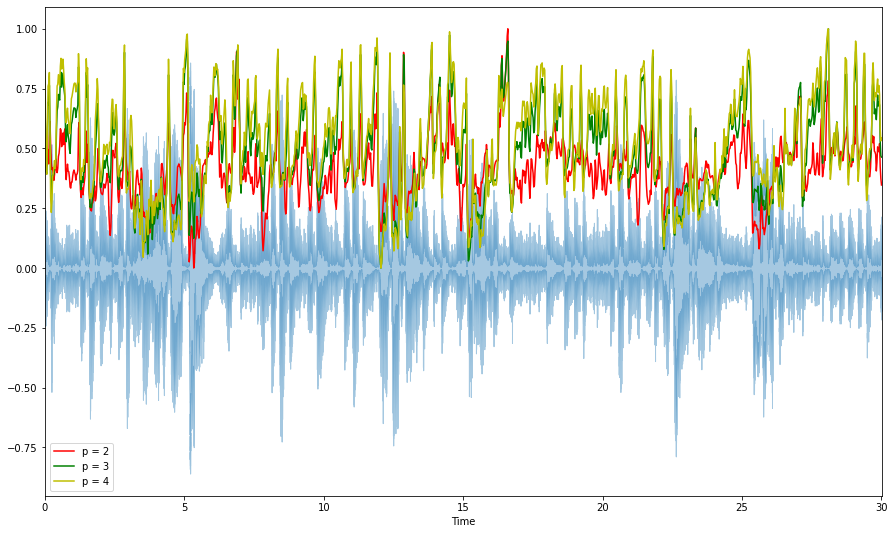

In [11]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=4)[0]
plt.figure(figsize=(15, 9))
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth_2), color='r')
plt.plot(t, normalize(spectral_bandwidth_3), color='g')
plt.plot(t, normalize(spectral_bandwidth_4), color='y')
plt.legend(('p = 2', 'p = 3', 'p = 4'))

### Song Classifier

In [12]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [13]:
import csv
import os
import numpy as np

file = open('dataset.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    for filename in os.listdir(f'/content/drive/MyDrive/Files/MCD/Procesamiento y Clasificación de Datos/Semana 10 - Análisis de Audio/Data/genres_original/{g}'):
        songname = f'/content/drive/MyDrive/Files/MCD/Procesamiento y Clasificación de Datos/Semana 10 - Análisis de Audio/Data/genres_original/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        rmse = librosa.feature.rms(y=y)[0]
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('dataset.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [14]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

data = pd.read_csv('/content/drive/MyDrive/Files/MCD/Procesamiento y Clasificación de Datos/Semana 10 - Análisis de Audio/Data/features_30_sec.csv')
data.head()# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)#Encoding the Labels
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)#Scaling the Feature columns
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))#Dividing data into training and Testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [15]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, ZeroPadding2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
classifier = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=32)

Epoch 1/50
25/25 [==============================] - 3s 2ms/step - loss: 1.8125 - accuracy: 0.3900
Epoch 2/50
25/25 [==============================] - 0s 2ms/step - loss: 1.1316 - accuracy: 0.6137
Epoch 3/50
25/25 [==============================] - 0s 2ms/step - loss: 0.8366 - accuracy: 0.7138
Epoch 4/50
25/25 [==============================] - 0s 2ms/step - loss: 0.6691 - accuracy: 0.7663
Epoch 5/50
25/25 [==============================] - 0s 2ms/step - loss: 0.5397 - accuracy: 0.8338
Epoch 6/50
25/25 [==============================] - 0s 2ms/step - loss: 0.4317 - accuracy: 0.8700
Epoch 7/50
25/25 [==============================] - 0s 2ms/step - loss: 0.3436 - accuracy: 0.9137
Epoch 8/50
25/25 [==============================] - 0s 2ms/step - loss: 0.2835 - accuracy: 0.9250
Epoch 9/50
25/25 [==============================] - 0s 2ms/step - loss: 0.2342 - accuracy: 0.9450
Epoch 10/50
25/25 [==============================] - 0s 2ms/step - loss: 0.1798 - accuracy: 0.9600
Epoch 11/50
25/25 [

### Conclusiones:

El análisis de audio tiene muchas aplicaciones en diferentes sectores tales como, el de entretenimiento y sector médico.

Se logra realizar una muy buena clasificación de las canciones en el conjunto de datos, alcanzando una exactitud del 99%. 

Debido a que la exactitud es muy alta, debería evaluarse el modelo con un conjunto de prueba para validar que no haya sobreajuste.